# Airbnb homestay price prediction

In [1]:
# Import the library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, validation_curve, learning_curve, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Data clean and preprocessing

In [2]:
# Import and concat the dataset
cities = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 
          'london', 'paris', 'rome', 'vienna']
days = ['weekdays', 'weekends']

k = 0

for city in cities:
    for day in days:
        file_name = '/Users/leowu/Desktop/Study_Materials/Data_Science2/Final_Project/Dataset/' + city + '_' + day + '.csv'
        data = pd.read_csv(file_name)
        data = data.drop(data.columns[0], axis=1)
        data['city'] = city
        data['week_time'] = day
        if k == 0:
            europe_data = data
            k = 1
        else:
            europe_data = pd.concat([europe_data, data])

In [3]:
# Change all values in a column to upper case
europe_data['city'] = europe_data['city'].apply(lambda x: x.title())

In [4]:
europe_data.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,week_time
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekdays


In [5]:
# View the dataset's shape
europe_data.shape

(51707, 21)

In [6]:
# Check the missing value of the dataset
europe_data.isna().sum()

realSum                       0
room_type                     0
room_shared                   0
room_private                  0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
cleanliness_rating            0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
attr_index                    0
attr_index_norm               0
rest_index                    0
rest_index_norm               0
lng                           0
lat                           0
city                          0
week_time                     0
dtype: int64

In [7]:
# View the descriptive information of continuous columns
europe_data.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.291353,0.350204,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.454390,0.477038,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694287,4.000000,1.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450285,6.000000,1.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


##### Data merge

In [8]:
# Introduce a new varaible called 'price_m2'
housing = pd.read_csv('/Users/leowu/Desktop/Study_Materials/Data_Science2/Final_Project/Housing_price.csv')
housing.head()

,Rank,City,Price per Square Meter to Buy Apartment
0,1,"Zurich, Switzerland",22835.78
1,2,"Geneva, Switzerland",18112.01
2,3,"London, United Kingdom",15154.73
3,4,"Lausanne, Switzerland",14848.88
4,5,"Munich, Germany",13229.05


In [9]:
# Create column 'Country' and 'city'
housing['Country'] = [i.split(', ')[1] for i in housing.City]
housing['city'] = [i.split(', ')[0] for i in housing.City]

In [10]:
housing.head()

,Rank,City,Price per Square Meter to Buy Apartment,Country,city
0,1,"Zurich, Switzerland",22835.78,Switzerland,Zurich
1,2,"Geneva, Switzerland",18112.01,Switzerland,Geneva
2,3,"London, United Kingdom",15154.73,United Kingdom,London
3,4,"Lausanne, Switzerland",14848.88,Switzerland,Lausanne
4,5,"Munich, Germany",13229.05,Germany,Munich


In [11]:
# Merge two dataframes
df = pd.merge(europe_data,
              housing[['Price per Square Meter to Buy Apartment ','city','Country']],
              how = 'inner',
              on = 'city')
df = df.rename(columns={'Price per Square Meter to Buy Apartment ': 'price_m2'})

In [12]:
# Introduce a new varaible called 'gdp_capita'
gdp = pd.read_csv('/Users/leowu/Desktop/Study_Materials/Data_Science2/Final_Project/imf-dm-export.csv')
gdp = gdp.rename(columns={'GDP per capita, current prices\n (U.S. dollars per capita)': 'Country'})
gdp = gdp.drop(index=0).reset_index(drop=True)
gdp.head()

,Country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,582.323,586.204,611.268,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,...,5257.714,5345.058,5268.239,6373.3,6369.009,6591.682,6968.694,7470.082,7958.016,8469.507
2,Algeria,2268.607,2305.505,2254.328,2316.679,2432.717,2753.697,2698.915,2705.111,2143.742,...,4118.839,3953.576,3304.865,3659.531,4151.437,4162.176,4242.401,4371.569,4523.644,4637.342
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,42229.903,40688.491,36973.845,41873.06,40722.63,40643.312,41732.561,42833.362,43788.262,44630.354
4,Angola,745.119,679.02,661.52,671.804,693.779,758.525,690.446,769.563,812.794,...,3465.062,2805.261,1873.11,2352.128,3790.704,3997.713,4071.392,4144.01,4222.687,4308.014


In [13]:
# We chose 2022 data and merge the dataframes together
df = pd.merge(df,
              gdp[['Country','2022']],
              how = 'inner',
              on = 'Country')

In [14]:
# Rename the column
df = df.rename(columns={'2022': 'GDP_capita'})
# df.to_csv('Final_dataset.csv', index=False)

In [15]:
# View the final dataframe
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,week_time,price_m2,Country,GDP_capita
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekdays,8647.36,Netherlands,56297.803
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekdays,8647.36,Netherlands,56297.803
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekdays,8647.36,Netherlands,56297.803
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekdays,8647.36,Netherlands,56297.803
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekdays,8647.36,Netherlands,56297.803


In [16]:
# View the shape of merged dataframe
df.shape

(51707, 24)

### Descriptive Analysis

##### Relationship between distance to city center & metro station and realSum

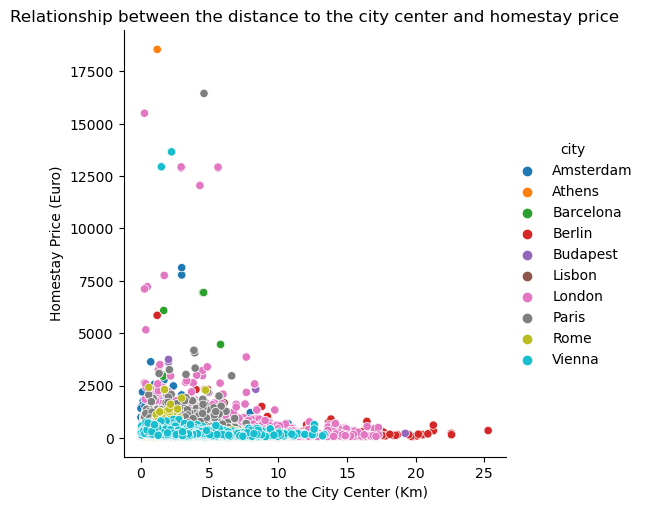

In [17]:
sns.relplot(x="dist", y="realSum", hue='city', data=df)
plt.xlabel("Distance to the City Center (Km)")
plt.ylabel("Homestay Price (Euro)")
plt.title("Relationship between the distance to the city center and homestay price")
plt.show()

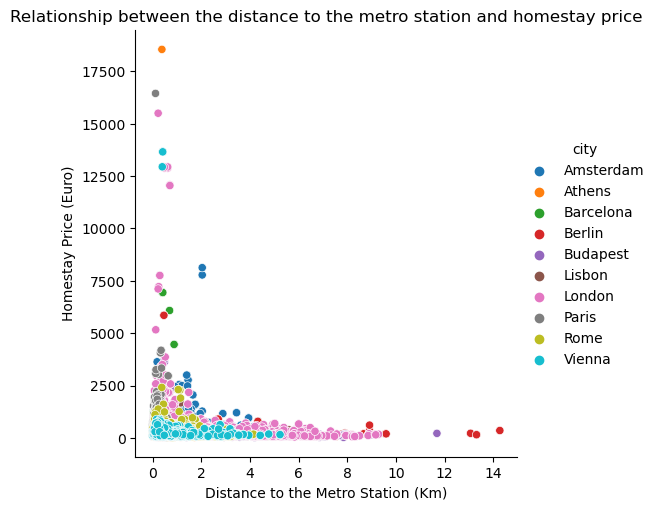

In [18]:
sns.relplot(x="metro_dist", y="realSum", hue='city', data=df)
plt.xlabel("Distance to the Metro Station (Km)")
plt.ylabel("Homestay Price (Euro)")
plt.title("Relationship between the distance to the metro station and homestay price")
plt.show()

##### Relationship between realSum and attr_index_norm & rest_index_norm

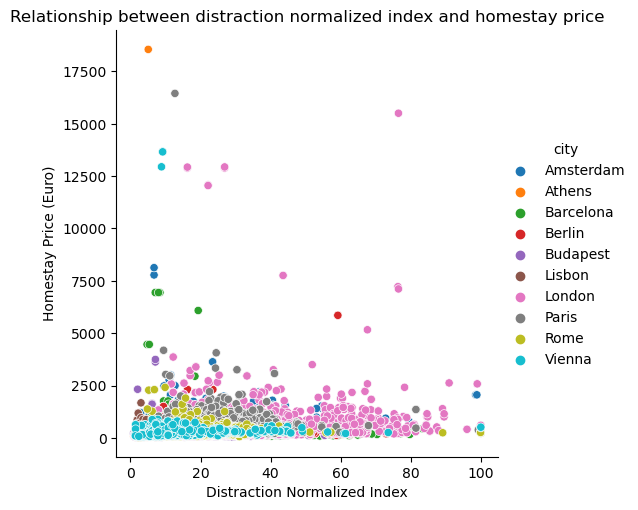

In [19]:
sns.relplot(x="attr_index_norm", y="realSum", hue='city', data=df)
plt.xlabel("Distraction Normalized Index")
plt.ylabel("Homestay Price (Euro)")
plt.title("Relationship between distraction normalized index and homestay price")
plt.show()

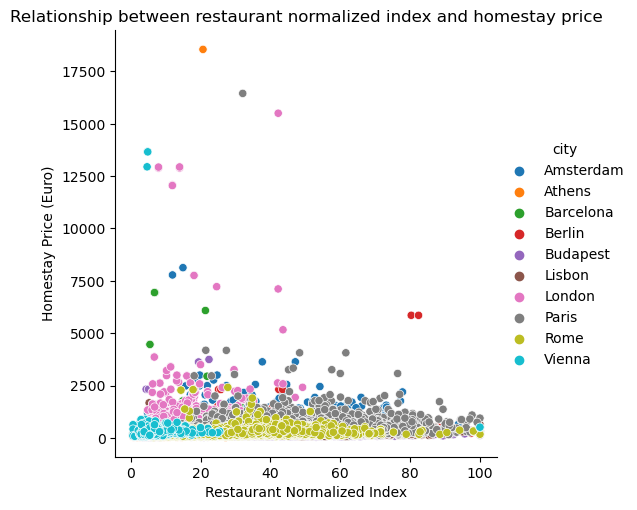

In [20]:
sns.relplot(x="rest_index_norm", y="realSum", hue='city', data=df)
plt.xlabel("Restaurant Normalized Index")
plt.ylabel("Homestay Price (Euro)")
plt.title("Relationship between restaurant normalized index and homestay price")
plt.show()

##### Relationship between realSum and GDP_capita & price_m2

In [21]:
# Create a new df to calculate the mean homestay price in each cities
df_avg = df.groupby('city').agg(mean_price=('realSum','mean')).reset_index()
df_avg

,city,mean_price
0,Amsterdam,573.112795
1,Athens,151.744121
2,Barcelona,293.753706
3,Berlin,244.583752
4,Budapest,176.513548
5,Lisbon,238.210479
6,London,362.469256
7,Paris,392.531403
8,Rome,205.391950
9,Vienna,241.582484


In [22]:
# Merge the table together
df_avg = pd.merge(df_avg,
              df[['city','GDP_capita','price_m2']],
              how = 'inner',
              on = 'city')
df_avg = df_avg.drop_duplicates()
df_avg['GDP_capita'] = df_avg['GDP_capita'].astype(float)
df_avg.head()

,city,mean_price,GDP_capita,price_m2
0,Amsterdam,573.112795,56297.803,8647.36
2080,Athens,151.744121,20875.779,2738.90
7360,Barcelona,293.753706,29198.086,5547.83
10193,Berlin,244.583752,48397.797,8707.22
12677,Budapest,176.513548,18982.752,3821.05


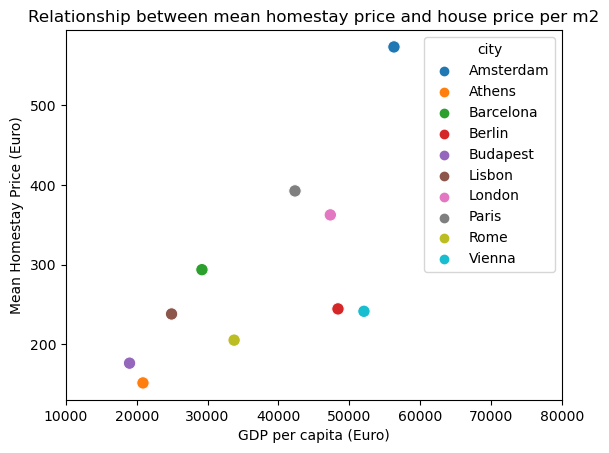

In [23]:
sns.scatterplot(y='mean_price', x='GDP_capita', hue='city', data=df_avg,s=80)

# add axis labels and title
plt.xlabel("GDP per capita (Euro)")
plt.ylabel("Mean Homestay Price (Euro)")
plt.title("Relationship between mean homestay price and house price per m2")

# adjust x-axis limits and ticks
plt.xlim(10000, 80000) # set x-axis limits
plt.xticks(range(10000, 80001, 10000)) # set x-axis tick marks at intervals of 1000

# show the plot
plt.show()

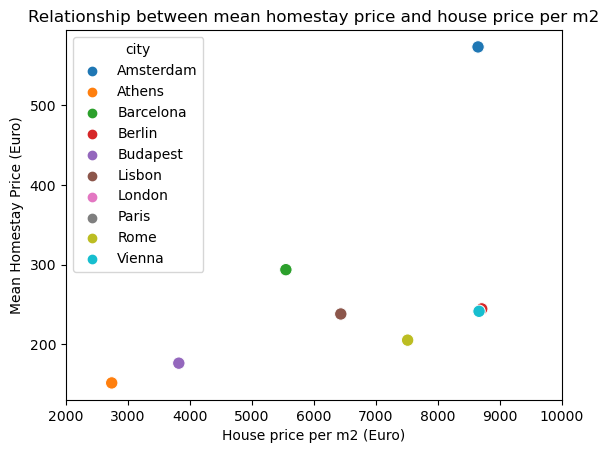

In [24]:
sns.scatterplot(y='mean_price', x='price_m2', hue='city', data=df_avg,s=80)

# add axis labels and title
plt.ylabel("Mean Homestay Price (Euro)")
plt.xlabel("House price per m2 (Euro)")
plt.title("Relationship between mean homestay price and house price per m2")

# adjust x-axis limits and ticks
plt.xlim(2000, 10000) # set x-axis limits
plt.xticks(range(2000, 10001, 1000)) # set x-axis tick marks at intervals of 1000

# show the plot
plt.show()

##### Room type

In [25]:
# Calculate the frequency of room type
room_type_values = df[['room_type', 'city']].value_counts().reset_index()
room_type_values.head()

,room_type,city,0
0,Entire home/apt,Rome,5561
1,Private room,London,5559
2,Entire home/apt,Paris,5067
3,Entire home/apt,Athens,4872
4,Entire home/apt,London,4384


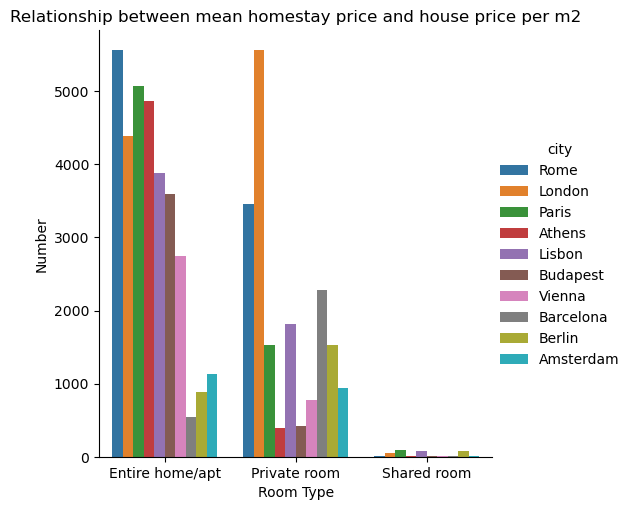

In [26]:
sns.catplot(y=0, x='room_type', hue='city', data=room_type_values,kind='bar')

# add axis labels and title
plt.xlabel("Room Type")
plt.ylabel("Number")
plt.title("Relationship between mean homestay price and house price per m2")

# show the plot
plt.show()

##### Person capacity

In [27]:
# Calculate the frequency of person capacity
person_capacity_values = df[['person_capacity', 'city']].value_counts().reset_index()
person_capacity_values.head()

,person_capacity,city,0
0,2.0,London,6207
1,2.0,Paris,3686
2,2.0,Rome,3431
3,4.0,Rome,2618
4,2.0,Lisbon,2341


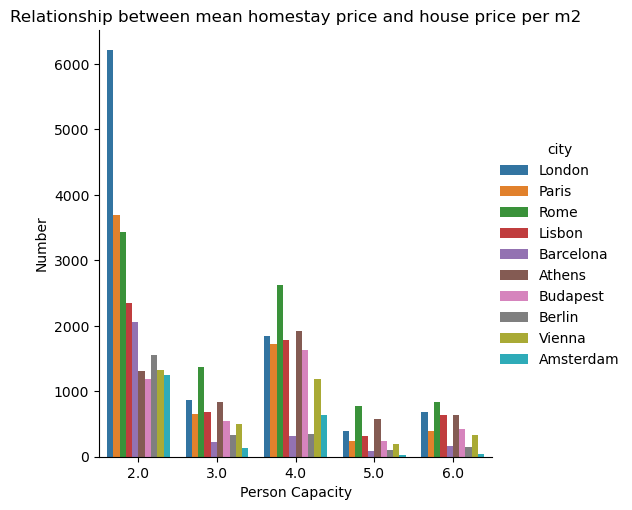

In [28]:
sns.catplot(y=0, x='person_capacity', hue='city', data=person_capacity_values,kind='bar')

# add axis labels and title
plt.xlabel("Person Capacity")
plt.ylabel("Number")
plt.title("Relationship between mean homestay price and house price per m2")

# show the plot
plt.show()

##### Superhost proportion in each city

In [29]:
df_super = df.groupby('city').agg(sum=('host_is_superhost','sum'),count=('host_is_superhost','count')).reset_index()
df_super['proportion'] = round(df_super['sum'] / df_super['count']*100,2)
df_super = df_super.sort_values(by='proportion',ascending=False).reset_index().drop(columns='index')
df_super

,city,sum,count,proportion
0,Athens,2263,5280,42.86
1,Budapest,1524,4022,37.89
2,Rome,2949,9027,32.67
3,Amsterdam,591,2080,28.41
4,Vienna,1005,3537,28.41
5,Berlin,639,2484,25.72
6,Lisbon,1233,5763,21.40
7,Barcelona,514,2833,18.14
8,London,1573,9993,15.74
9,Paris,941,6688,14.07


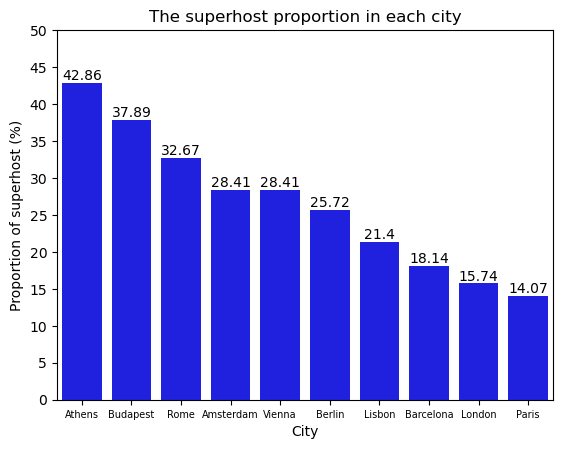

In [30]:
# Create a bar plot using Seaborn
sns.barplot(x='city', y='proportion',data=df_super,color ='blue')

# Add axis labels and title
plt.xlabel("City")
plt.ylabel("Proportion of superhost (%)")
# add labels to the bars
for index, row in df_super.iterrows():
    plt.annotate(round(row['proportion'],2), xy=(index, round(row['proportion'],2)), ha='center', va='bottom')
plt.title("The superhost proportion in each city")
plt.ylim(0, 50) # set x-axis limits
plt.yticks(range(0, 51, 5)) 
plt.gca().set_xticklabels(df_super['city'], fontsize=7)
# Show the plot
plt.show()

##### Cleanliness rate

In [31]:
df_clean = df.groupby('city').agg(clean=('cleanliness_rating','mean')).reset_index()
df_clean = df_clean.sort_values(by='clean',ascending=False).reset_index().drop(columns='index')
df_clean

,city,clean
0,Athens,9.638447
1,Rome,9.514678
2,Budapest,9.477374
3,Vienna,9.472434
4,Amsterdam,9.465865
5,Berlin,9.461755
6,Lisbon,9.370640
7,Barcelona,9.291564
8,Paris,9.263606
9,London,9.175023


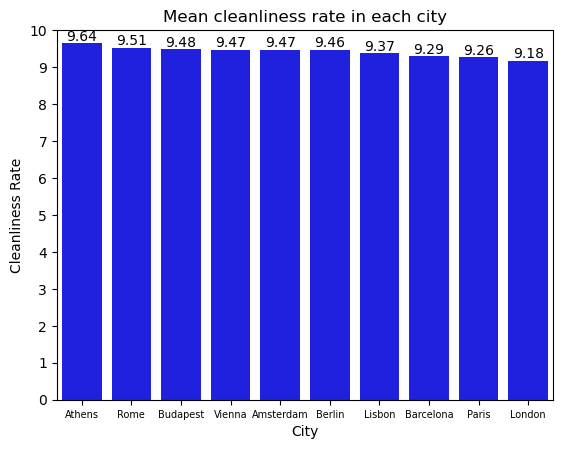

In [32]:
# Create a bar plot using Seaborn
sns.barplot(x='city', y='clean',data=df_clean,color='blue')

# Add axis labels and title
plt.xlabel("City")
plt.ylabel("Cleanliness Rate")
# add labels to the bars
for index, row in df_clean.iterrows():
    plt.annotate(round(row['clean'],2), xy=(index, round(row['clean'],2)), ha='center', va='bottom')
plt.title("Mean cleanliness rate in each city")
plt.ylim(0, 10) # set x-axis limits
plt.yticks(range(0, 11, 1)) 
plt.gca().set_xticklabels(df_clean['city'], fontsize=7)
# Show the plot
plt.show()

##### Overall guest satisfaction

In [33]:
df_guest = df.groupby('city').agg(satis=('guest_satisfaction_overall','mean')).reset_index()
df_guest = df_guest.sort_values(by='satis',ascending=False).reset_index().drop(columns='index')
df_guest

,city,satis
0,Athens,95.003598
1,Budapest,94.585281
2,Amsterdam,94.514423
3,Berlin,94.323671
4,Vienna,93.731128
5,Rome,93.122300
6,Paris,92.037530
7,Barcelona,91.109072
8,Lisbon,91.093875
9,London,90.645652


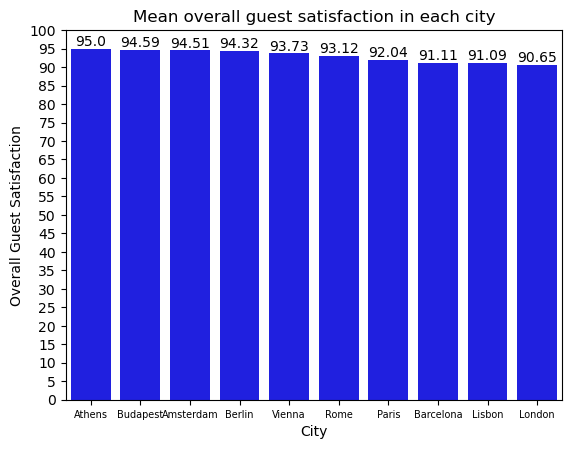

In [34]:
# Create a bar plot using Seaborn
sns.barplot(x='city', y='satis',data=df_guest,color ='blue')

# Add axis labels and title
plt.xlabel("City")
plt.ylabel("Overall Guest Satisfaction")
# add labels to the bars
for index, row in df_guest.iterrows():
    plt.annotate(round(row['satis'],2), xy=(index, round(row['satis'],2)), ha='center', va='bottom')
plt.title("Mean overall guest satisfaction in each city")
plt.ylim(0, 100) # set x-axis limits
plt.yticks(range(0, 101, 5)) 
plt.gca().set_xticklabels(df_guest['city'], fontsize=7)
# Show the plot
plt.show()

##### Week time

In [35]:
df_week = df.groupby(['city','week_time']).agg(mean=('realSum','mean')).reset_index()
df_week.head()

,city,week_time,mean
0,Amsterdam,weekdays,545.020526
1,Amsterdam,weekends,604.828018
2,Athens,weekdays,155.866982
3,Athens,weekends,147.580456
4,Barcelona,weekdays,288.391667


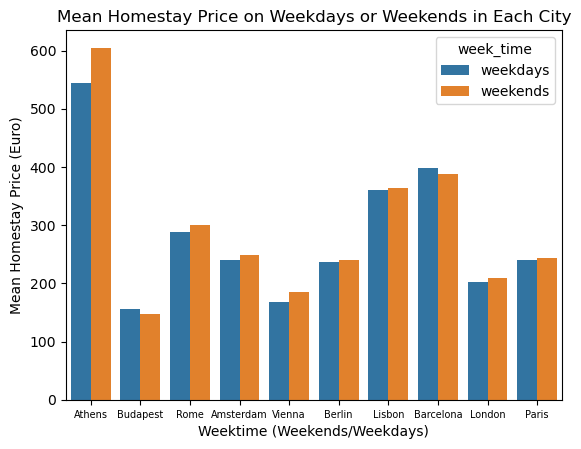

In [36]:
# Create a bar plot using Seaborn
sns.barplot(x='city', y='mean', hue='week_time', data=df_week)

# Add axis labels and title
plt.xlabel("Weektime (Weekends/Weekdays)")
plt.ylabel("Mean Homestay Price (Euro)")
plt.title("Mean Homestay Price on Weekdays or Weekends in Each City")
plt.gca().set_xticklabels(df_super['city'], fontsize=7)
# Show the plot
plt.show()

##### For binary variables 'room_shared', 'room_private', 'host_is_superhost', 'multi' and 'biz'
research the relationship between realSum and them

In [37]:
# Define a function to generate a new df
def con(a):
    df1 = df.groupby(a).agg(mean=('realSum','mean')).reset_index()
    df1['type'] = a
    df1.columns = ['value','mean','type']
    return df1

In [38]:
# Execute the function
list1 = ['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz']
df_binary = pd.concat([con(a) for a in list1]).reset_index().drop(columns=['index'])
df_binary

,value,mean,type
0,0,280.851343,room_shared
1,1,143.566164,room_shared
2,0,322.311330,room_private
3,1,204.940233,room_private
4,0,288.625905,host_is_superhost
5,1,254.447726,host_is_superhost
6,0,291.008758,multi
7,1,252.810560,multi
8,0,270.937024,biz
9,1,296.472330,biz


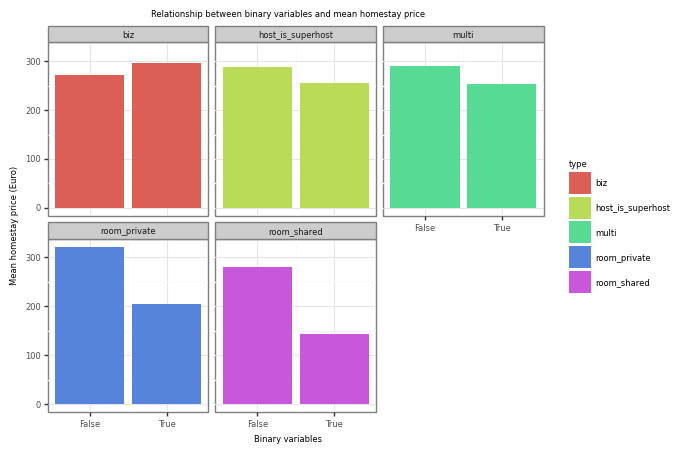

<ggplot: (8766304191269)>

In [39]:
# Visualize the results
ggplot(df_binary, aes(x='value',y='mean',fill='type')) +\
geom_col(position='dodge') +\
facet_wrap('type')+\
labs(title = 'Relationship between binary variables and mean homestay price',\
     x = 'Binary variables', y = 'Mean homestay price (Euro)')+\
scale_x_continuous(breaks=(0,1),labels=('False','True'))+\
theme_bw()+\
theme(text = element_text(size=6))

## Prediction by using machine learning models

#### Transform some variables' forms

In [40]:
## Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['room_type','room_shared','room_private','host_is_superhost','week_time'], drop_first=True)
df.head()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,...,city,price_m2,Country,GDP_capita,room_type_Private room,room_type_Shared room,room_shared_True,room_private_True,host_is_superhost_True,week_time_weekends
0,194.033698,2.0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,...,Amsterdam,8647.36,Netherlands,56297.803,1,0,0,1,0,0
1,344.245776,4.0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,...,Amsterdam,8647.36,Netherlands,56297.803,1,0,0,1,0,0
2,264.101422,2.0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,...,Amsterdam,8647.36,Netherlands,56297.803,1,0,0,1,0,0
3,433.529398,4.0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,...,Amsterdam,8647.36,Netherlands,56297.803,1,0,0,1,0,0
4,485.552926,2.0,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,...,Amsterdam,8647.36,Netherlands,56297.803,1,0,0,1,1,0


#### Select feature arrays and target array

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/43072605.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

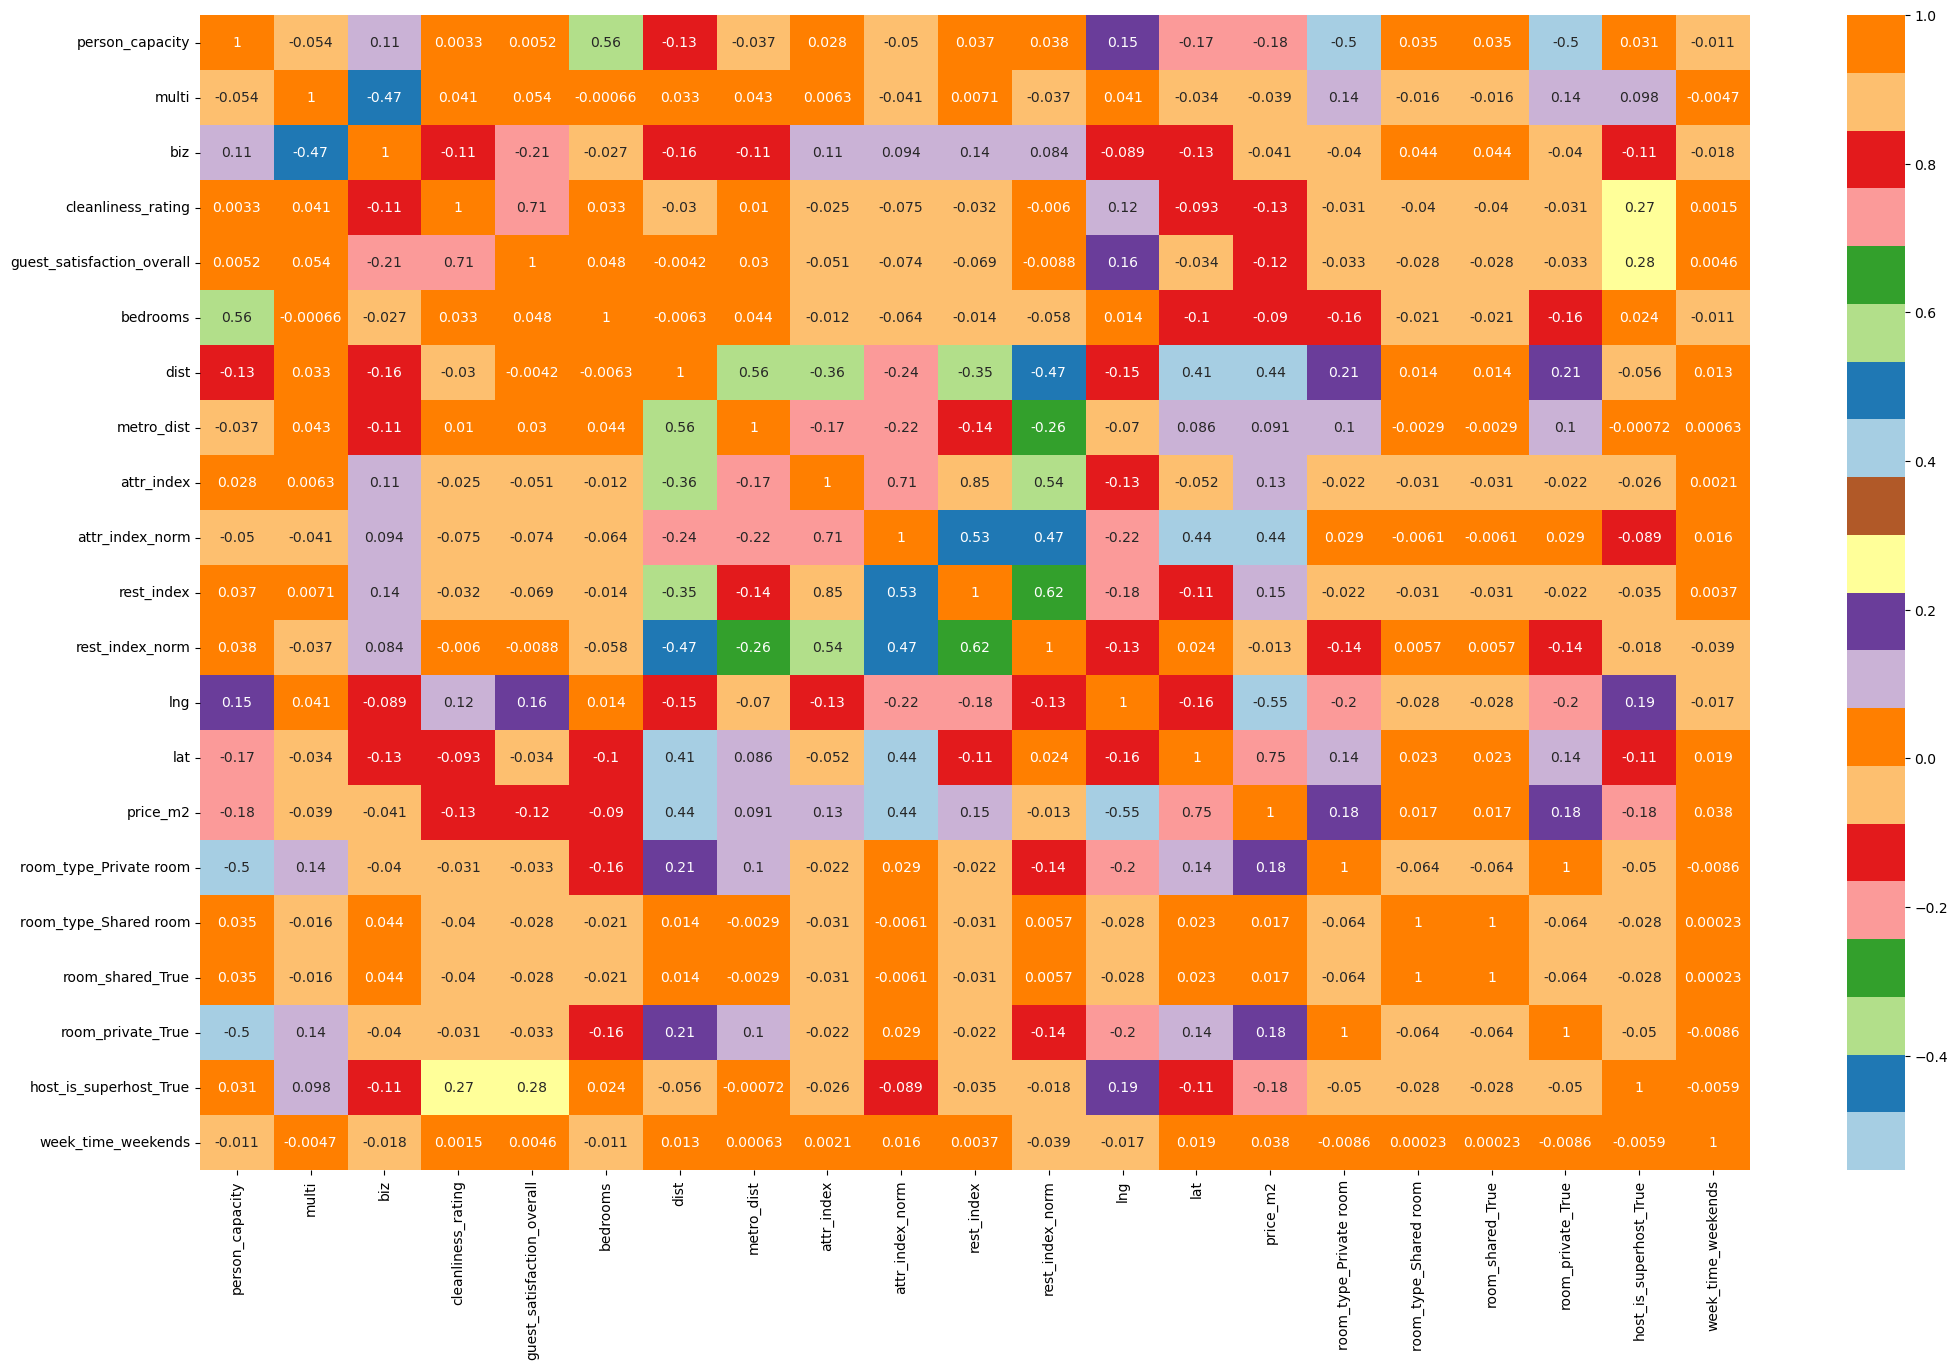

In [41]:
# Check the feature correlation
plt.figure
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 15))
sns.heatmap(df.drop(['realSum'], axis = 1).corr(),cmap=sns.color_palette("Paired",20),annot=True,ax=axes)

##### There are features tha have perfect corelation, thus these are the redundant features and it is safe to remove one of them. Thus we will remove 'room_shared_True' and 'room_private_True'.

In [42]:
list2 = ['attr_index','rest_index','city','Country','realSum','room_shared_True','room_private_True']
y = df.realSum
X = df.drop(list2, axis = 1)
# Standardize features to eliminate issues of scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=10)

In [43]:
## Describe the training and test shape
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', ytrain.shape[0])
print('Testing Features Shape:', Xtest.shape)
print('Testing Labels Shape:', ytest.shape[0])

Training Features Shape: (41365, 18)
Training Labels Shape: 41365
Testing Features Shape: (10342, 18)
Testing Labels Shape: 10342


#### Define some functions for measure the model performance

In [44]:
# Define RMSE function
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5)).mean()
    return rmse

In [45]:
# Define evaluation function
def evaluation(y_train, y_train_pred, y_test, y_test_pred):
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r_squared = r2_score(y_train, y_train_pred)
    
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r_squared = r2_score(y_test, y_test_pred)
    
    return train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared

### Different machine learning models

In [46]:
# Generate a new df to compare different models
models = pd.DataFrame()

#### Linear Regression

In [47]:
# Linear Regression Model
lr = LinearRegression()
lr.fit(Xtrain, ytrain)

# Predict values for test dataset
y_train_pred = lr.predict(Xtrain)
y_test_pred = lr.predict(Xtest)

train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared = \
evaluation(ytrain, y_train_pred, ytest, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)
print("Training R2 Score:", train_r_squared)
print("-"*30)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)

rmse_cross_val = rmse_cv(lr)

print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "LinearRegression","Training MAE": train_mae, "Training MSE": train_mse,\
           "Training RMSE": train_rmse, "Training R2 Score": train_r_squared, "Test MAE": test_mae, \
           "Test MSE": test_mse, "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Training MAE: 105.34177577425395
Training MSE: 85724.40013257448
Training RMSE: 292.78729503271563
Training R2 Score: 0.21916846858194672
------------------------------
Test MAE: 100.78303370725861
Test MSE: 75731.06379171385
Test RMSE: 275.19277568954067
Test R2 Score: 0.23159134883119226
------------------------------
RMSE Cross-Validation: 325.86716831408893


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/2965438615.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### Ridge Regression

In [48]:
# Define a list of alpha values to test
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

# Create an empty list to store the r2 scores for each alpha
scores = []

# Loop through the alpha values and fit the Ridge model using each one
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(Xtrain,ytrain)
    scores.append(model.score(Xtest, ytest))

# Find the alpha value with the highest r2 score
best_alpha = alphas[np.argmax(scores)]
best_score = np.max(scores)

print("Best alpha:", best_alpha)
print("Best score:", best_score)

Best alpha: 100
Best score: 0.2316121026026765


In [49]:
# Ridge Regression Model(alpha = 100)
ridge = Ridge(alpha=100)
ridge.fit(Xtrain, ytrain)

# Predict values for test dataset
ytrain_pre_ridge = ridge.predict(Xtrain)
ytest_pre_ridge = ridge.predict(Xtest)

train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared = \
evaluation(ytrain, ytrain_pre_ridge, ytest, ytest_pre_ridge)
print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", train_rmse)
print("Training R2 Score:", train_r_squared)
print("-"*30)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)

rmse_cross_val = rmse_cv(ridge)
print("RMSE Cross-Validation:", rmse_cross_val)

new_row = {"Model": "Ridge", "Training MAE": train_mae, "Training MSE": train_mse, "Training RMSE": train_rmse,\
           "Training R2 Score": train_r_squared, "Test MAE": test_mae, "Test MSE": test_mse, \
           "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Training MAE: 105.2718837072125
Training MSE: 85724.83535517614
Training RMSE: 292.7880382720171
Training R2 Score: 0.21916450430188128
------------------------------
Test MAE: 100.71097053990952
Test MSE: 75729.01838893266
Test RMSE: 275.18905935544143
Test R2 Score: 0.2316121026026765
------------------------------
RMSE Cross-Validation: 321.2993651797196


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/2581777524.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


#### Lasso Regression

In [50]:
# Define a list of alpha values to test
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

# Create an empty list to store the r2 scores for each alpha
scores1 = []

# Loop through the alpha values and fit the Ridge model using each one
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(Xtrain,ytrain)
    scores1.append(model.score(Xtest, ytest))

# Find the alpha value with the highest r2 score
best_alpha = alphas[np.argmax(scores1)]
best_score = np.max(scores1)

print("Best alpha:", best_alpha)
print("Best score:", best_score)

Best alpha: 0.0001
Best score: 0.2315913337448101


In [51]:
# Lasso Regression Model(alpha = 0.0001)
lasso = Lasso(alpha=0.0001)
lasso.fit(Xtrain, ytrain)

# Predict values for test dataset
ytrain_pre_lasso = lasso.predict(Xtrain)
ytest_pre_lasso = lasso.predict(Xtest)

train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared = \
evaluation(ytrain, ytrain_pre_lasso, ytest, ytest_pre_lasso)
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2 Score:", train_r_squared)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)

rmse_cross_val = rmse_cv(lasso)
print("RMSE Cross-Validation:", rmse_cross_val)

# Append results to models dataframe
new_row = {"Model": "Lasso", "Training MAE": train_mae, "Training MSE": train_mse, "Training RMSE": train_rmse,\
           "Training R2 Score": train_r_squared, "Test MAE": test_mae, "Test MSE": test_mse, \
           "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Train MAE: 105.34171157542748
Train MSE: 85724.40013299053
Train RMSE: 292.7872950334262
Train R2 Score: 0.21916846857815697
Test MAE: 100.78297348022534
Test MSE: 75731.06527856302
Test RMSE: 275.1927783910091
Test R2 Score: 0.2315913337448101
------------------------------
RMSE Cross-Validation: 325.8655855933913


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/1337211897.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


##### Compare the feature importance of RIdge and Lasso

In [52]:
pd.DataFrame({'Variable': X.columns, 'Ridge Coef': ridge.coef_,\
              'Lasso Coef': lasso.coef_})

,Variable,Ridge Coef,Lasso Coef
0,person_capacity,24.520324,24.408520
1,multi,2.126464,2.192065
2,biz,8.563121,8.624135
3,cleanliness_rating,4.801673,4.780486
4,guest_satisfaction_overall,7.091982,7.124746
5,bedrooms,59.509970,59.647439
6,dist,-7.311602,-6.992247
7,metro_dist,-5.980233,-6.091300
8,attr_index_norm,66.031402,66.484458
9,rest_index_norm,5.365139,5.245497


### Decision Tree Model

Best max_depth: 10


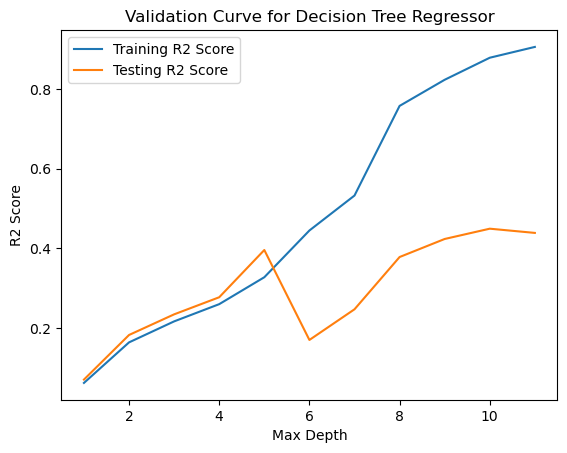

In [53]:
# Range of maximum tree depth
max_set = range(1, 12)

# Create a decision tree regressor
tree = DecisionTreeRegressor()

train_r2_scores = []
test_r2_scores = []

for max_depth in max_set:
    # Set maximum tree depth
    tree.set_params(max_depth=max_depth)

    # Fit the model on training data
    tree.fit(Xtrain, ytrain)

    # Predict on training and testing data
    y_train_pred = tree.predict(Xtrain)
    y_test_pred = tree.predict(Xtest)

    # Calculate R2 scores
    train_r2 = r2_score(ytrain, y_train_pred)
    test_r2 = r2_score(ytest, y_test_pred)

    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Find the index of the maximum test score
max_depth_idx = np.argmax(test_r2_scores)

# Find the corresponding value of max_depth
best_max_depth = max_set[max_depth_idx]

print("Best max_depth:", best_max_depth)

# Plot the scores
plt.plot(max_set, train_r2_scores, label='Training R2 Score')
plt.plot(max_set, test_r2_scores, label='Testing R2 Score')
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.title('Validation Curve for Decision Tree Regressor')
plt.legend(loc='best')
# plt.axvline(x=best_max_depth, color='green', linestyle='--', label='Best max_depth')
# plt.text(best_max_depth, max(test_r2_scores), f"Best max_depth={best_max_depth}", ha='right', va='top', color='green')
plt.show()

##### We selected 5 as max depth for Decision Tree Model

In [54]:
# Fit model
tree5 = DecisionTreeRegressor(max_depth=5)
tree5.fit(Xtrain, ytrain)

## The predict value of test dataset
ytrain_pre_tree = tree5.predict(Xtrain)
ytest_pre_tree = tree5.predict(Xtest)

train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared = \
evaluation(ytrain, ytrain_pre_tree, ytest, ytest_pre_tree)
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2 Score:", train_r_squared)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)

rmse_cross_val = rmse_cv(tree5)
print("RMSE Cross-Validation:", rmse_cross_val)

# Append results to models dataframe
new_row = {"Model": "Decision Tree", "Training MAE": train_mae, "Training MSE": train_mse, "Training RMSE": train_rmse,\
           "Training R2 Score": train_r_squared, "Test MAE": test_mae, "Test MSE": test_mse, \
           "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Train MAE: 94.70000446675432
Train MSE: 73857.28434238305
Train RMSE: 271.7669669816092
Train R2 Score: 0.3272615923791402
Test MAE: 90.99431675749044
Test MSE: 59567.234492654556
Test RMSE: 244.0639967153176
Test R2 Score: 0.3955983711486577
------------------------------
RMSE Cross-Validation: 294.7160710644406


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/3982718886.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


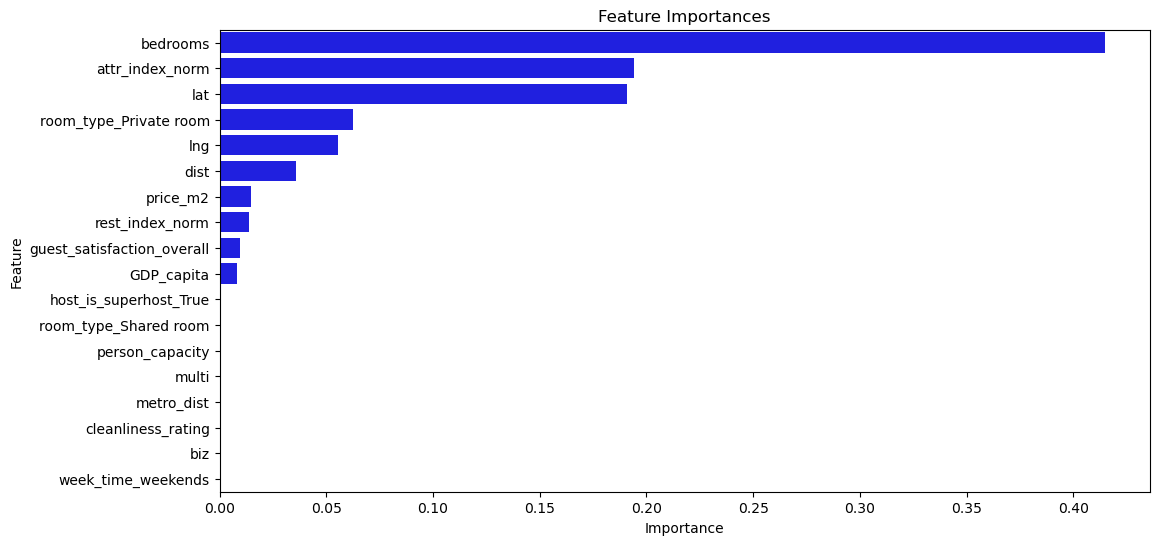

In [55]:
# Get the feature importance values
importances = tree5.feature_importances_

# Create a dataframe to store the feature importances
feature_importance = pd.DataFrame({'feature': Xtrain.columns, 'importance': importances})

# Sort the dataframe by importance values
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Create a bar plot to visualize the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, color='blue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Random Forest Model

Best max_depth: 10


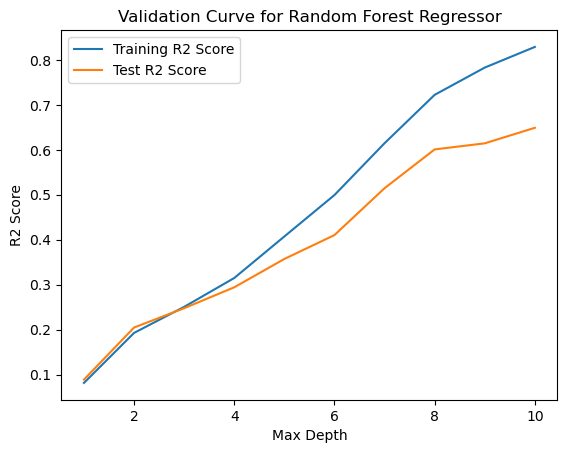

In [56]:
# Define a range of max_depth values
max_depth_range = range(1, 11)

# Create a random forest regressor
rf = RandomForestRegressor()

# Create empty lists to store the R2 scores for the training and test sets
train_r2_scores = []
test_r2_scores = []
    
for max_depth in max_depth_range:
    # Set maximum tree depth
    rf.set_params(max_depth=max_depth)

    # Fit the model on training data
    rf.fit(Xtrain, ytrain)

    # Predict on training and testing data
    y_train_pred = rf.predict(Xtrain)
    y_test_pred = rf.predict(Xtest)

    # Calculate R2 scores
    train_r2 = r2_score(ytrain, y_train_pred)
    test_r2 = r2_score(ytest, y_test_pred)

    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    
# Find the index of the maximum test R2 score, and use it to determine the best value of max_depth
best_index = test_r2_scores.index(max(test_r2_scores))
best_max_depth = max_depth_range[best_index]
print("Best max_depth:", best_max_depth)

# Plot the R2 scores for the training and test sets
plt.plot(max_depth_range, train_r2_scores, label='Training R2 Score')
plt.plot(max_depth_range, test_r2_scores, label='Testing R2 Score')
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.title('Validation Curve for Random Forest Regressor')
plt.legend()
plt.show()

##### We selected 5 as max depth for Random Forest Model

In [57]:
# Fit model
forest5 = RandomForestRegressor(max_depth=5)
forest5.fit(Xtrain, ytrain)

## The predict value of test dataset
ytrain_pre_forest = forest5.predict(Xtrain)
ytest_pre_forest = forest5.predict(Xtest)

train_mae, train_mse, train_rmse, train_r_squared, test_mae, test_mse, test_rmse, test_r_squared = \
evaluation(ytrain, ytrain_pre_forest, ytest, ytest_pre_forest)
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2 Score:", train_r_squared)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)

rmse_cross_val = rmse_cv(forest5)
print("RMSE Cross-Validation:", rmse_cross_val)

# Append results to models dataframe
new_row = {"Model": "Random Forest", "Training MAE": train_mae, "Training MSE": train_mse, "Training RMSE": train_rmse,\
           "Training R2 Score": train_r_squared, "Test MAE": test_mae, "Test MSE": test_mse, \
           "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Train MAE: 88.60577560157483
Train MSE: 66632.26789122951
Train RMSE: 258.1322682099809
Train R2 Score: 0.3930715677344664
Test MAE: 86.24947755784916
Test MSE: 63146.86058481434
Test RMSE: 251.29039095201063
Test R2 Score: 0.3592775337082871
------------------------------
RMSE Cross-Validation: 286.73509313437444


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/2433954204.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


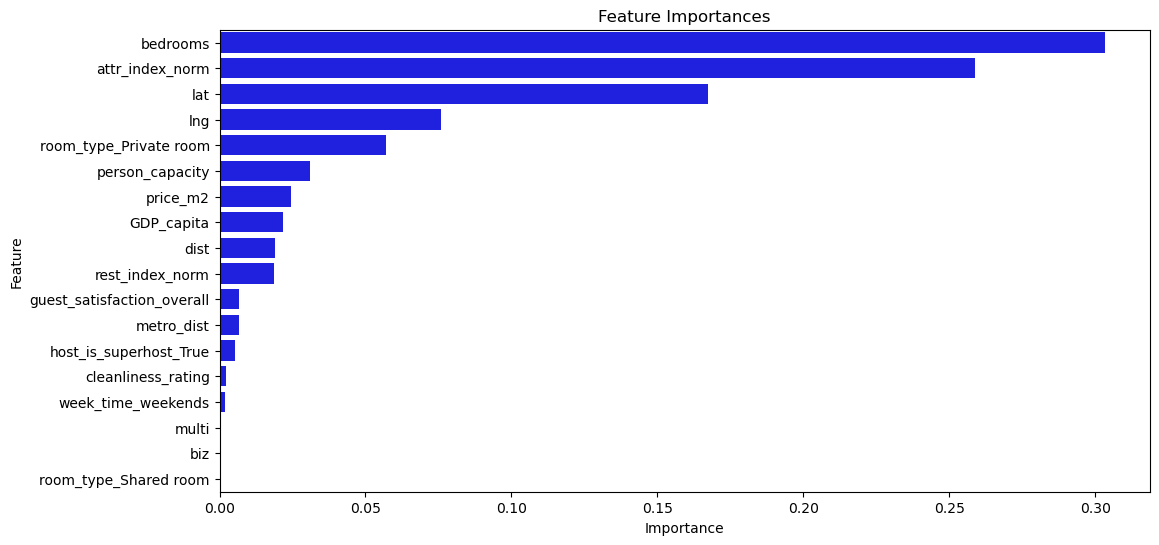

In [58]:
# Get the feature importance values
importances = forest5.feature_importances_

# Create a dataframe to store the feature importances
feature_importance = pd.DataFrame({'feature': Xtrain.columns, 'importance': importances})

# Sort the dataframe by importance values
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Create a bar plot to visualize the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance,color='blue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### XGBoost Regressor

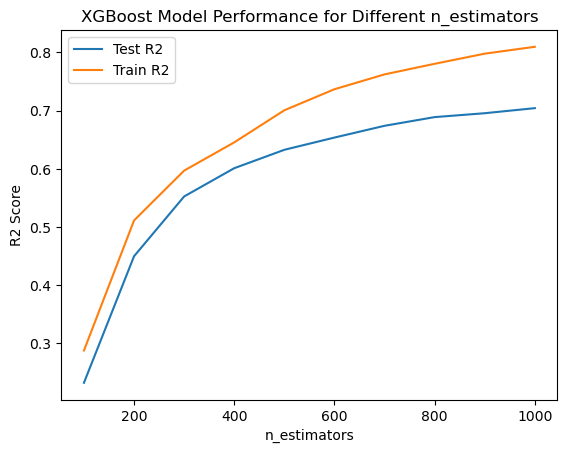

In [59]:
# Create empty lists to store results
test_r2_list = []
train_r2_list = []

# Define range of values for n_estimators
n_estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Loop through values of n_estimators
for n in n_estimators_list:
    # Create XGBoost model with different n_estimators
    xgb = XGBRegressor(n_estimators=n, learning_rate=0.01)
    xgb.fit(Xtrain, ytrain)

    # Evaluate model performance
    ytrain_pre_xg = xgb.predict(Xtrain)
    train_r2 = r2_score(ytrain, ytrain_pre_xg)
    ytest_pre_xg = xgb.predict(Xtest)
    test_r2 = r2_score(ytest, ytest_pre_xg)

    # Append results to lists
    test_r2_list.append(test_r2)
    train_r2_list.append(train_r2)

# Create line plot of test R2 score and training R2 score for different values of n_estimators
plt.plot(n_estimators_list, train_r2_list, label='Training R2 Score')
plt.plot(n_estimators_list, test_r2_list, label='Testing R2 Score')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('R2 Score')
plt.title('XGBoost Model Performance for Different n_estimators')
plt.show()

##### We selected 400 as n_estimators for XGBoost Model

In [62]:
# XGBoost Regressor model with early stopping and regularization
xgb = XGBRegressor(n_estimators=400, learning_rate=0.01)
#, objective='reg:squarederror', reg_lambda=1, reg_alpha=0.1
# Fit the model on the training data with early stopping based on the test set performance
xgb.fit(Xtrain, ytrain)
#, eval_set=[(Xtest, ytest)], early_stopping_rounds=10, verbose=False
# Predict the target variable on training and test data
ytrain_pre_xg = xgb.predict(Xtrain)
ytest_pre_xg = xgb.predict(Xtest)

# Evaluate the performance of the model
train_mae = mean_absolute_error(ytrain, ytrain_pre_xg)
train_mse = mean_squared_error(ytrain, ytrain_pre_xg)
train_rmse = np.sqrt(train_mse)
train_r_squared = r2_score(ytrain, ytrain_pre_xg)
test_mae = mean_absolute_error(ytest, ytest_pre_xg)
test_mse = mean_squared_error(ytest, ytest_pre_xg)
test_rmse = np.sqrt(test_mse)
test_r_squared = r2_score(ytest, ytest_pre_xg)

# Print the evaluation metrics
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train R2 Score:", train_r_squared)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test R2 Score:", test_r_squared)
print("-"*30)
rmse_cross_val = rmse_cv(xgb)
print("RMSE Cross-Validation:", rmse_cross_val)

# Append the results to the models dataframe
new_row = {"Model": "XGBoost", "Training MAE": train_mae, "Training MSE": train_mse, "Training RMSE": train_rmse,\
           "Training R2 Score": train_r_squared, "Test MAE": test_mae, "Test MSE": test_mse, \
           "Test RMSE": test_rmse, "Test R2 Score": test_r_squared, "RMSE (Cross-Validation)": rmse_cross_val}
models = models.append(new_row, ignore_index=True)

Train MAE: 70.78500496557616
Train MSE: 38924.18439372166
Train RMSE: 197.29212957875856
Train R2 Score: 0.6454541476832192
Test MAE: 71.03886454662407
Test MSE: 39321.588510435475
Test RMSE: 198.29671835518477
Test R2 Score: 0.6010217303665474
------------------------------
RMSE Cross-Validation: 284.553339465384


/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_9819/382775488.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


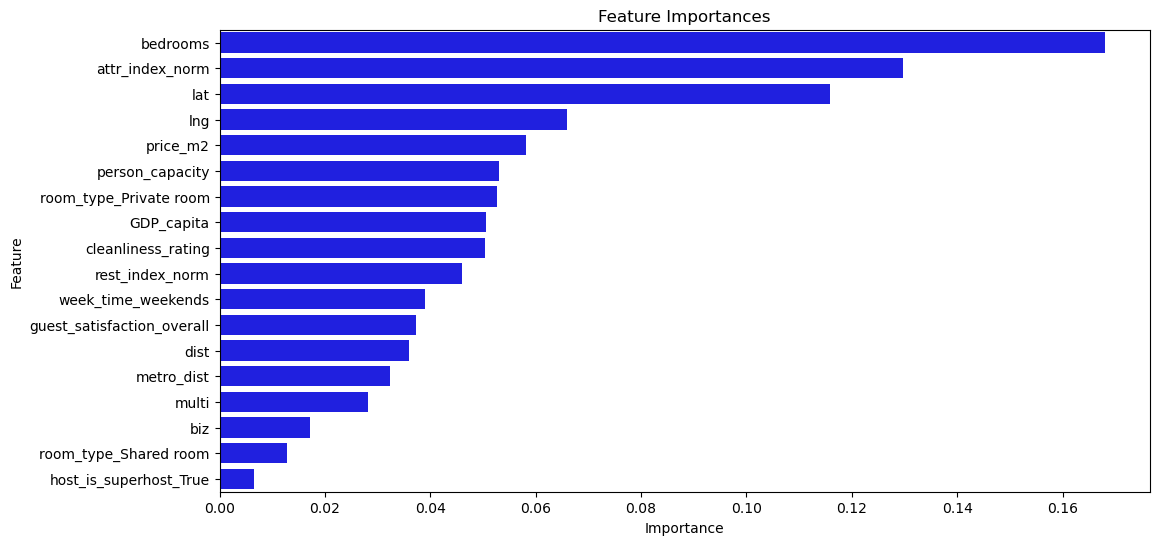

In [63]:
# Get the feature importance values
importances = xgb.feature_importances_

# Create a dataframe to store the feature importances
feature_importance = pd.DataFrame({'feature': Xtrain.columns, 'importance': importances})

# Sort the dataframe by importance values
feature_importance.sort_values(by='importance', ascending=False, inplace=True)

# Create a bar plot to visualize the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, color='blue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Model Comparison
The less the Root Mean Squared Error (RMSE), The better the model is.

In [64]:
models.sort_values(by="RMSE (Cross-Validation)")

,Model,Training MAE,Training MSE,Training RMSE,Training R2 Score,Test MAE,Test MSE,Test RMSE,Test R2 Score,RMSE (Cross-Validation)
5,XGBoost,70.785005,38924.184394,197.292130,0.645454,71.038865,39321.588510,198.296718,0.601022,284.553339
4,Random Forest,88.605776,66632.267891,258.132268,0.393072,86.249478,63146.860585,251.290391,0.359278,286.735093
3,Decision Tree,94.700004,73857.284342,271.766967,0.327262,90.994317,59567.234493,244.063997,0.395598,294.716071
1,Ridge,105.271884,85724.835355,292.788038,0.219165,100.710971,75729.018389,275.189059,0.231612,321.299365
2,Lasso,105.341712,85724.400133,292.787295,0.219168,100.782973,75731.065279,275.192778,0.231591,325.865586
0,LinearRegression,105.341776,85724.400133,292.787295,0.219168,100.783034,75731.063792,275.192776,0.231591,325.867168


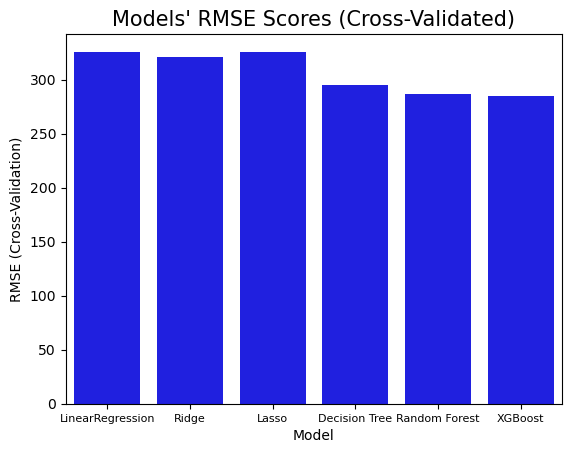

In [65]:
#plt.figure(figsize=(12,6))
sns.barplot(x=models["Model"], y=models["RMSE (Cross-Validation)"],color='blue')
plt.title("Models' RMSE Scores (Cross-Validated)", size=15)
plt.xticks(size=8)
plt.show()

### Compare the feature importance of decision tree, random forest and XGBoost

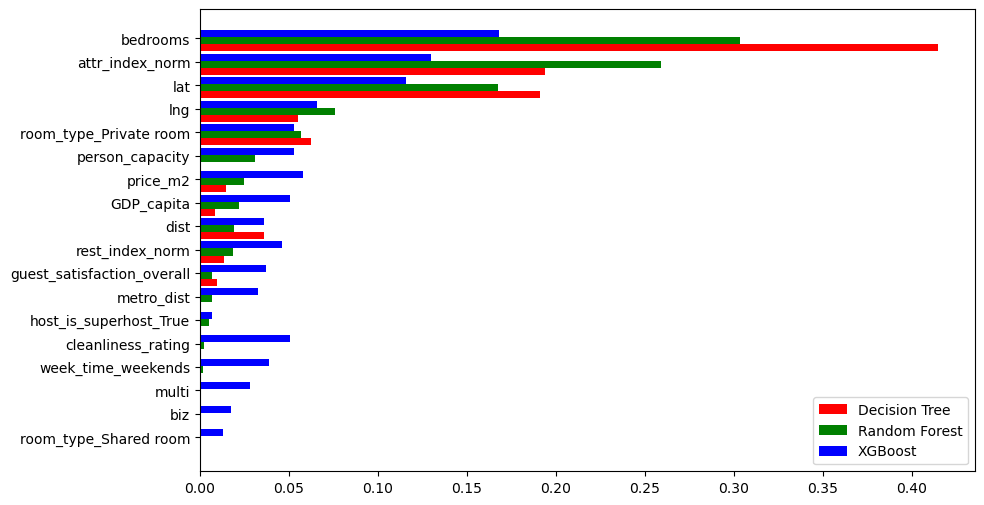

In [66]:
feature_importance=pd.DataFrame({
    'rfc':forest5.feature_importances_,
    'dt':tree5.feature_importances_,
    'xgb':xgb.feature_importances_,
},index=df.drop(list2, axis = 1).columns)
feature_importance.sort_values(by='rfc',ascending=True,inplace=True)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(10,6))
dt_feature=ax.barh(index,feature_importance['dt'],0.3,color='red',label='Decision Tree')
rfc_feature=ax.barh(index+0.3,feature_importance['rfc'],0.3,color='green',label='Random Forest')
xgb_feature=ax.barh(index+0.6,feature_importance['xgb'],0.3,color='blue',label='XGBoost')
ax.set(yticks=index+0.4,yticklabels=feature_importance.index)

ax.legend()
plt.show()
